# Libraries

In [50]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet169
from keras.applications.resnet import ResNet101

from keras.applications import MobileNetV2, Xception
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical

# Importing Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/neural-networks-fer-data'
os.listdir(path)

['example_submission.csv', 'icml_face_data.csv', 'test.csv', 'train.csv']

In [4]:
# Load Data
data = pd.read_csv(path+'/icml_face_data.csv')

In [5]:
data.head()


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


# Preprocessing Data

In [6]:
# Helper functions for the data
def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

    bar_label = emotions.values()

    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])

    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()

    plt.show()

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()

    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()

    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()

    plt.show()

In [7]:
data[' Usage'].value_counts()

 Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [8]:
# Remove Disgust Data
data = data[data['emotion'] != 1]
data.head()
data.count()

emotion    35340
 Usage     35340
 pixels    35340
dtype: int64

In [9]:
data[' Usage'].value_counts()

 Usage
Training       28273
PrivateTest     3534
PublicTest      3533
Name: count, dtype: int64

In [10]:
selected_rows = data[(data[' Usage'] == 'Training') & (data['emotion'] == 3)]
selected_rows.count()

emotion    7215
 Usage     7215
 pixels    7215
dtype: int64

In [11]:
# Place Neutral data as emotion 1 rather than 6
data.loc[data['emotion'] == 6, 'emotion'] = 1

In [12]:
# Prepare data
emotions = {0: 'Angry', 1: 'Neutral', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise'}

Define training, validation and test data:

In [13]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

Reshape and scale the images:

In [14]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

Encoding of the target value:

In [15]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [16]:
print(train_labels)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


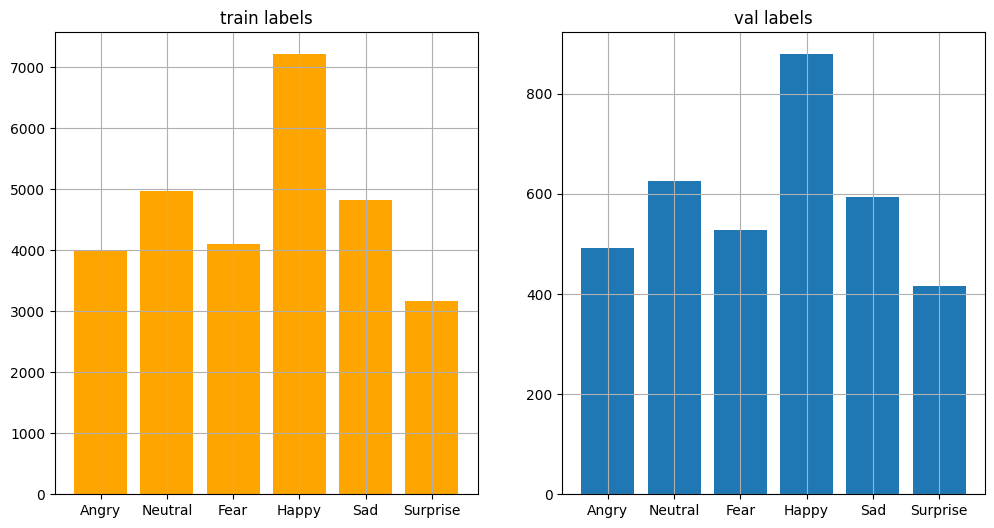

In [17]:
# Distribution of labels
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [18]:
class_weight = dict(zip(range(0, 6), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [ ]:
class_weight

{0: 0.14130088777278677,
 1: 0.17560923849609167,
 2: 0.1449085700137941,
 3: 0.25519046440066495,
 4: 0.17083436494181728,
 5: 0.11215647437484526}

# Models

## Simple CNN

In [ ]:
# Simple CNN model
simple_model = models.Sequential()
simple_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
simple_model.add(BatchNormalization())
simple_model.add(MaxPool2D((2, 2)))
simple_model.add(Conv2D(64, (3, 3), activation='relu'))
simple_model.add(MaxPool2D((2, 2)))
simple_model.add(Conv2D(64, (3, 3), activation='relu'))
simple_model.add(Flatten())
simple_model.add(Dense(64, activation='relu'))
simple_model.add(Dense(6, activation='softmax'))

In [ ]:
simple_model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                        

In [37]:
history = simple_model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=20,
                    batch_size=32)

NameError: name 'simple_model' is not defined

In [ ]:
test_loss_simple, test_acc_simple = simple_model.evaluate(test_images, test_labels)
pred_test_labels_simple = simple_model.predict(test_images)
print('test accuracy:', test_acc_simple)

111/111 [==============================] - 0s 4ms/step
test accuracy: 0.5256156325340271


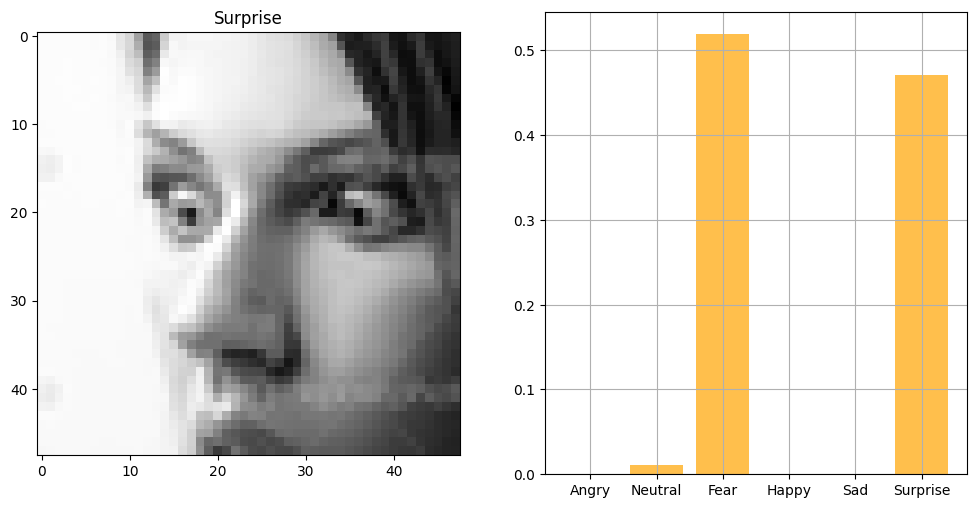

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 106)

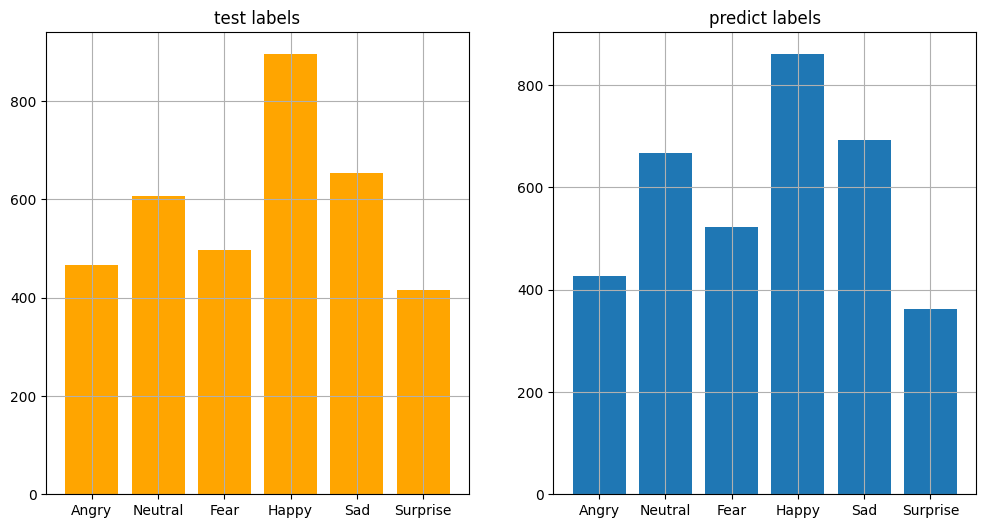

In [ ]:
plot_compare_distributions(test_labels, pred_test_labels_simple, title1='test labels', title2='predict labels')

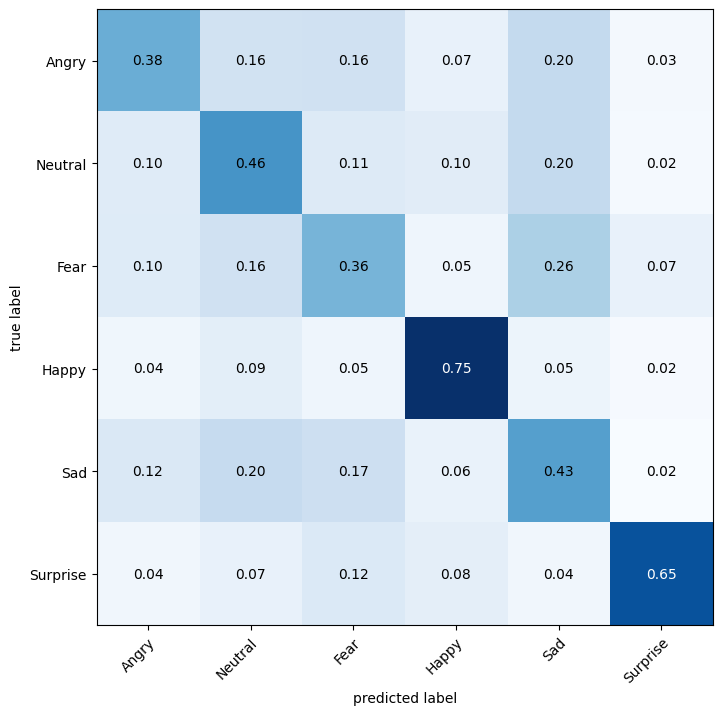

In [ ]:
# analyze the confusion matrix to see what emotions are often confused
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels_simple.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

## VGG16

In [ ]:
# initialize a vgg16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

layers_to_freeze = 15  # For example, freeze the first 15 layers

for layer in vgg16.layers[:layers_to_freeze]:
    layer.trainable = False

# use transfer learning from vgg16
vgg_model = models.Sequential()
vgg_model.add(vgg16)
vgg_model.add(Flatten())
vgg_model.add(Dropout(.3))
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dropout(.3))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
vgg_model.add(Dense(128, activation='relu'))
vgg_model.add(Dense(6, activation='softmax'))

vgg_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

vgg_model.summary()





58889256/58889256 [==============================] - 0s 0us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 6)                

In [ ]:
train_images_vgg = np.stack((train_images[:, :, :, 0],)*3, axis=-1)

val_images_vgg = np.stack((val_images[:, :, :, 0],)*3, axis=-1)

test_images_vgg = np.stack((test_images[:, :, :, 0],)*3, axis=-1)

In [ ]:
# Train model
history = vgg_model.fit(train_images_vgg, train_labels, epochs=20, batch_size=64, class_weight=class_weight, validation_data=(val_images_vgg, val_labels))

Epoch 1/20
442/442 [==============================] - 11s 17ms/step - loss: 0.2972 - accuracy: 0.2541 - val_loss: 1.7995 - val_accuracy: 0.2487
Epoch 2/20
442/442 [==============================] - 5s 12ms/step - loss: 0.2952 - accuracy: 0.2552 - val_loss: 1.8201 - val_accuracy: 0.2487
Epoch 3/20
442/442 [==============================] - 5s 12ms/step - loss: 0.2952 - accuracy: 0.2552 - val_loss: 1.7989 - val_accuracy: 0.2487
Epoch 4/20
442/442 [==============================] - 6s 13ms/step - loss: 0.2951 - accuracy: 0.2552 - val_loss: 1.8076 - val_accuracy: 0.2487
Epoch 5/20
442/442 [==============================] - 5s 12ms/step - loss: 0.2952 - accuracy: 0.2552 - val_loss: 1.7929 - val_accuracy: 0.2487
Epoch 6/20
442/442 [==============================] - 6s 13ms/step - loss: 0.2951 - accuracy: 0.2552 - val_loss: 1.7908 - val_accuracy: 0.2487
Epoch 7/20
442/442 [==============================] - 5s 12ms/step - loss: 0.2951 - accuracy: 0.2552 - val_loss: 1.7982 - val_accuracy: 0.248

In [ ]:
test_loss_vgg, test_acc_vgg = vgg_model.evaluate(test_images_vgg, test_labels)
pred_test_labels_vgg = vgg_model.predict(test_images_vgg)
print('test acc:', test_acc_vgg)

111/111 [==============================] - 1s 4ms/step
test acc: 0.25332579016685486


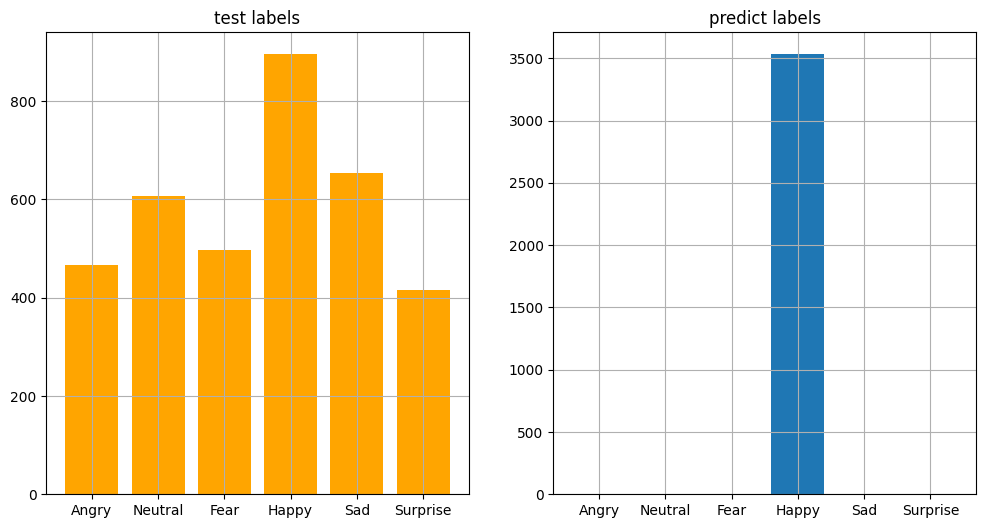

In [ ]:
plot_compare_distributions(test_labels, pred_test_labels_vgg, title1='test labels', title2='predict labels')

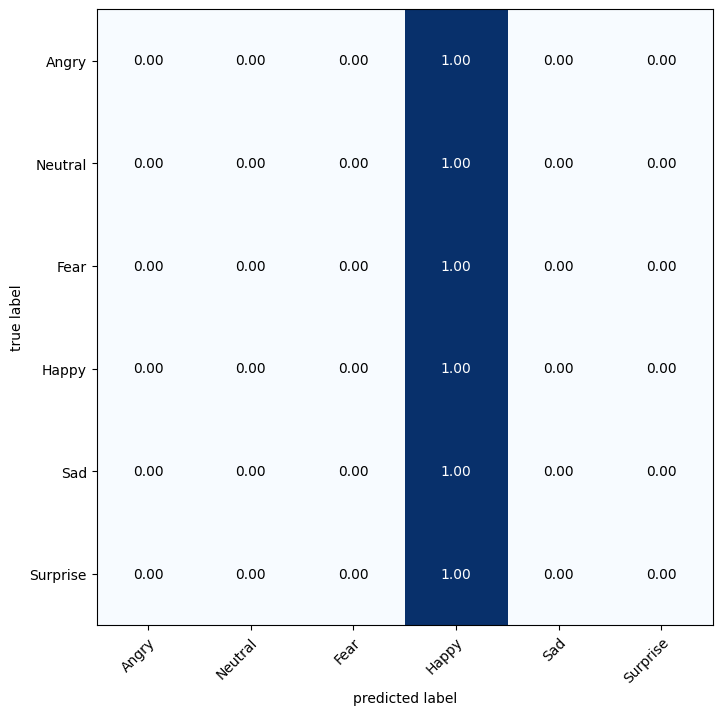

In [ ]:
# analyze the confusion matrix to see what emotions are often confused
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels_vgg.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

## DenseNet

In [ ]:
# initialize a densenet
densenet = DenseNet169(
    include_top=False,
    weights='imagenet',
    input_shape=(48,48,3)

)



layers_to_freeze = 25  # For example, freeze the first 15 layers

for layer in densenet.layers[:layers_to_freeze]:
    layer.trainable = False

# use transfer learning from vgg16
densenet_model = models.Sequential()
densenet_model.add(densenet)
densenet_model.add(Flatten())
densenet_model.add(Dropout(.3))
densenet_model.add(Dense(256, activation='relu'))
densenet_model.add(Dropout(.3))
# densenet_model.add(Dense(256, activation='relu'))
# densenet_model.add(Dropout(0.5))
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dense(6, activation='softmax'))

densenet_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

densenet_model.summary()





51877672/51877672 [==============================] - 2s 0us/step


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 flatten_2 (Flatten)         (None, 1664)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1664)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               426240    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                

In [ ]:
train_images_densenet = np.stack((train_images[:, :, :, 0],)*3, axis=-1)

val_images_densenet = np.stack((val_images[:, :, :, 0],)*3, axis=-1)

test_images_densenet = np.stack((test_images[:, :, :, 0],)*3, axis=-1)

In [ ]:
history = densenet_model.fit(train_images_densenet, train_labels, epochs=20, batch_size=64, class_weight=class_weight, validation_data=(val_images_densenet, val_labels))

Epoch 1/20
442/442 [==============================] - 150s 131ms/step - loss: 0.2494 - accuracy: 0.4014 - val_loss: 1.7316 - val_accuracy: 0.4290
Epoch 2/20
442/442 [==============================] - 51s 116ms/step - loss: 0.2087 - accuracy: 0.4921 - val_loss: 1.6663 - val_accuracy: 0.4502
Epoch 3/20
442/442 [==============================] - 52s 118ms/step - loss: 0.1930 - accuracy: 0.5403 - val_loss: 1.1810 - val_accuracy: 0.5419
Epoch 4/20
442/442 [==============================] - 51s 116ms/step - loss: 0.1847 - accuracy: 0.5564 - val_loss: 1.3800 - val_accuracy: 0.4941
Epoch 5/20
442/442 [==============================] - 52s 117ms/step - loss: 0.1824 - accuracy: 0.5651 - val_loss: 1.2605 - val_accuracy: 0.4873
Epoch 6/20
442/442 [==============================] - 51s 116ms/step - loss: 0.1692 - accuracy: 0.5980 - val_loss: 1.0652 - val_accuracy: 0.5945
Epoch 7/20
442/442 [==============================] - 51s 116ms/step - loss: 0.1542 - accuracy: 0.6385 - val_loss: 1.0316 - val_a

In [ ]:
test_loss_densenet, test_acc_densenet = densenet_model.evaluate(test_images_densenet, test_labels)
pred_test_labels_densenet = densenet_model.predict(test_images_densenet)
print('test acc:', test_acc_densenet)

NameError: name 'densenet_model' is not defined

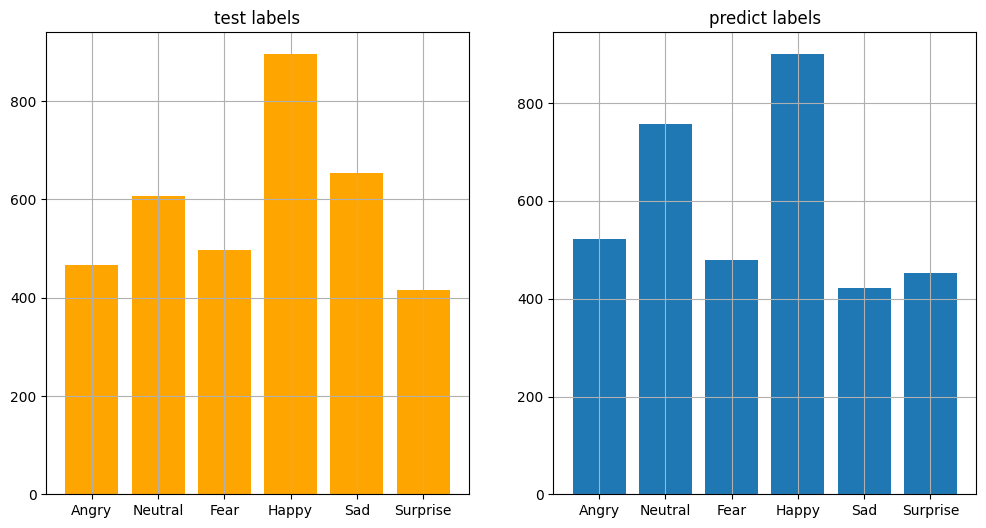

In [ ]:
plot_compare_distributions(test_labels, pred_test_labels_densenet, title1='test labels', title2='predict labels')

In [ ]:
# analyze the confusion matrix to see what emotions are often confused
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels_densenet.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

## ResNet

In [ ]:
# initialize a resnet
resnet = ResNet101(
    include_top=False,
    weights='imagenet',
    input_shape=(48,48,3)

)



layers_to_freeze = 15  # For example, freeze the first 15 layers

# for layer in vgg16.layers[:layers_to_freeze]:
#     layer.trainable = False

# use transfer learning from vgg16
resnet_model = models.Sequential()
resnet_model.add(resnet)
resnet_model.add(Flatten())
resnet_model.add(Dropout(.3))
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dropout(.3))
# resnet_model.add(Dense(256, activation='relu'))
# resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(6, activation='softmax'))

resnet_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

resnet_model.summary()





171446536/171446536 [==============================] - 5s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2, 2, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 6)                 7

In [ ]:
train_images_resnet = np.stack((train_images[:, :, :, 0],)*3, axis=-1)

val_images_resnet = np.stack((val_images[:, :, :, 0],)*3, axis=-1)

test_images_resnet = np.stack((test_images[:, :, :, 0],)*3, axis=-1)

In [ ]:
history = resnet_model.fit(train_images_resnet, train_labels, epochs=20, batch_size=64, class_weight=class_weight, validation_data=(val_images_resnet, val_labels))

Epoch 1/20
442/442 [==============================] - 122s 102ms/step - loss: 0.2804 - accuracy: 0.3321 - val_loss: 1.7912 - val_accuracy: 0.1494
Epoch 2/20
442/442 [==============================] - 42s 94ms/step - loss: 0.2317 - accuracy: 0.4320 - val_loss: 1.7730 - val_accuracy: 0.2538
Epoch 3/20
442/442 [==============================] - 41s 93ms/step - loss: 0.2249 - accuracy: 0.4489 - val_loss: 1.2923 - val_accuracy: 0.4864
Epoch 4/20
442/442 [==============================] - 41s 93ms/step - loss: 0.2060 - accuracy: 0.5004 - val_loss: 1.2882 - val_accuracy: 0.4859
Epoch 5/20
442/442 [==============================] - 41s 92ms/step - loss: 0.1991 - accuracy: 0.5223 - val_loss: 1.6076 - val_accuracy: 0.3563
Epoch 6/20
442/442 [==============================] - 41s 93ms/step - loss: 0.2156 - accuracy: 0.4773 - val_loss: 1.5830 - val_accuracy: 0.3625
Epoch 7/20
442/442 [==============================] - 40s 91ms/step - loss: 0.2045 - accuracy: 0.5046 - val_loss: 1.5008 - val_accurac

In [ ]:
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(test_images_resnet, test_labels)
pred_test_labels_resnet = resnet_model.predict(test_images_resnet)
print('test acc:', test_acc_resnet)

111/111 [==============================] - 3s 14ms/step
test acc: 0.48400792479515076


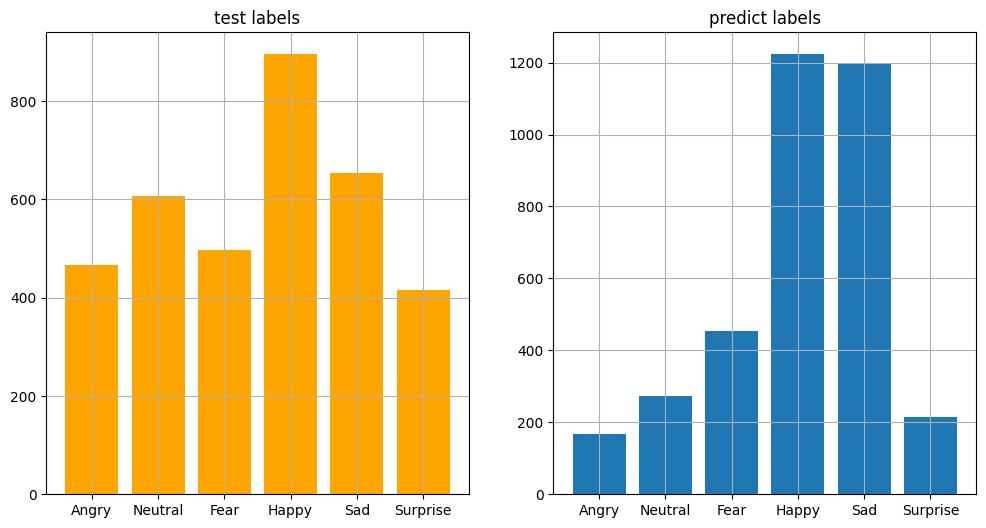

In [ ]:
plot_compare_distributions(test_labels, pred_test_labels_resnet, title1='test labels', title2='predict labels')

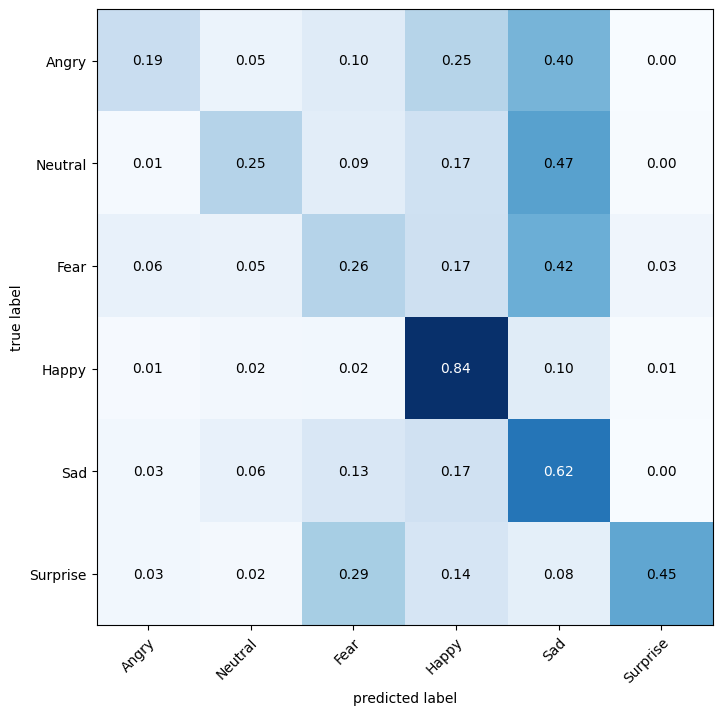

In [ ]:
# analyze the confusion matrix to see what emotions are often confused
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels_resnet.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

## MobileNet

In [ ]:
# initialize a mobile
mobilenet = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(48,48,3)

)



layers_to_freeze = 15  # For example, freeze the first 15 layers

# for layer in vgg16.layers[:layers_to_freeze]:
#     layer.trainable = False

# use transfer learning from vgg16
mobilenet_model = models.Sequential()
mobilenet_model.add(mobilenet)
mobilenet_model.add(Flatten())
mobilenet_model.add(Dropout(.3))
mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(.3))
# mobilenet_model.add(Dense(256, activation='relu'))
# mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(Dense(128, activation='relu'))
mobilenet_model.add(Dense(6, activation='softmax'))

mobilenet_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

mobilenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_3 (Flatten)         (None, 5120)              0         
                                                                 
 dropout_4 (Dropout)         (None, 5120)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               1310976   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                      

In [ ]:
train_images_mobilenet = np.stack((train_images[:, :, :, 0],)*3, axis=-1)

val_images_mobilenet = np.stack((val_images[:, :, :, 0],)*3, axis=-1)

test_images_mobilenet = np.stack((test_images[:, :, :, 0],)*3, axis=-1)

In [ ]:
history = mobilenet_model.fit(train_images_mobilenet, train_labels, epochs=20, batch_size=64, class_weight=class_weight, validation_data=(val_images_mobilenet, val_labels))

Epoch 1/20
442/442 [==============================] - 45s 40ms/step - loss: 0.2625 - accuracy: 0.3713 - val_loss: 3.6458 - val_accuracy: 0.3347
Epoch 2/20
442/442 [==============================] - 15s 35ms/step - loss: 0.2165 - accuracy: 0.4800 - val_loss: 3.5166 - val_accuracy: 0.3480
Epoch 3/20
442/442 [==============================] - 15s 35ms/step - loss: 0.2064 - accuracy: 0.5050 - val_loss: 2.1117 - val_accuracy: 0.4137
Epoch 4/20
442/442 [==============================] - 16s 35ms/step - loss: 0.1971 - accuracy: 0.5265 - val_loss: 2.5877 - val_accuracy: 0.3447
Epoch 5/20
442/442 [==============================] - 16s 35ms/step - loss: 0.1851 - accuracy: 0.5589 - val_loss: 2.0631 - val_accuracy: 0.4980
Epoch 6/20
442/442 [==============================] - 16s 36ms/step - loss: 0.1899 - accuracy: 0.5496 - val_loss: 3.0948 - val_accuracy: 0.3291
Epoch 7/20
442/442 [==============================] - 15s 35ms/step - loss: 0.2122 - accuracy: 0.4932 - val_loss: 2.0752 - val_accuracy:

In [ ]:
test_loss_mobilenet, test_acc_mobilenet = mobilenet_model.evaluate(test_images_mobilenet, test_labels)
pred_test_labels_mobilenet = mobilenet_model.predict(test_images_mobilenet)
print('test acc:', test_acc_mobilenet)

111/111 [==============================] - 1s 6ms/step
test acc: 0.5103311538696289


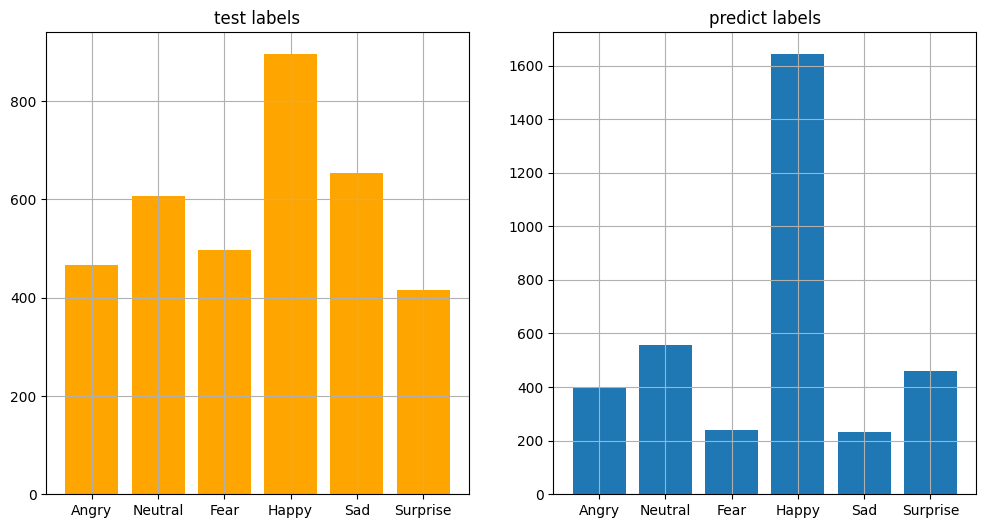

In [ ]:
plot_compare_distributions(test_labels, pred_test_labels_mobilenet, title1='test labels', title2='predict labels')

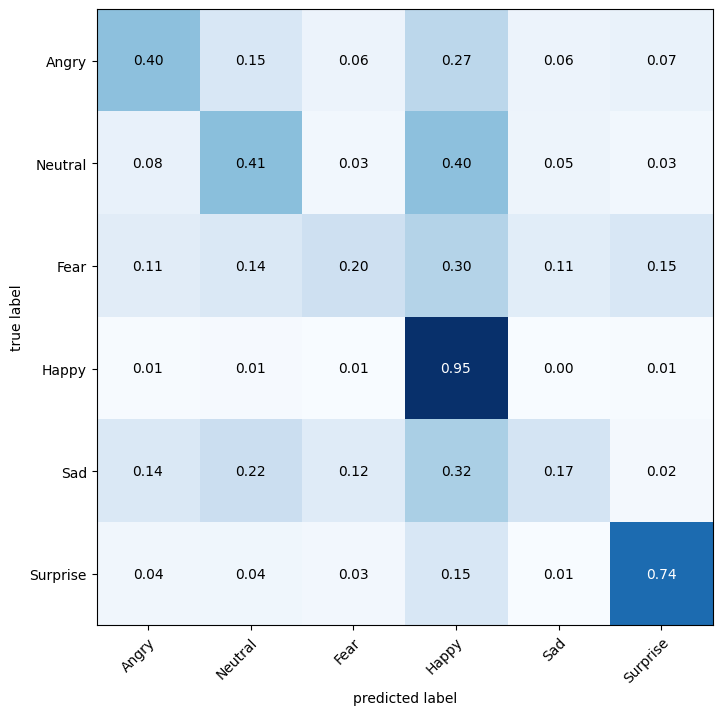

In [ ]:
# analyze the confusion matrix to see what emotions are often confused
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels_mobilenet.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

In [ ]:
# analyze the confusion matrix to see what emotions are often confused
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels_xception.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

# Data Augmentation

In [19]:
# create a dictionary which stores the indices of each emotion
def create_emotion_dict(train_labels):
    emotion_dict = {'angry': [], 'neutral': [], 'fear': [], 'happy': [], 'sad': [], 'surprise': []}

    # Iterate through train_labels
    for i, labels in enumerate(train_labels):
        for j, label in enumerate(labels):
            # Determine the emotion based on the index j
            if label == 1:
                if j == 0:
                    emotion_dict['angry'].append(i)
                elif j == 1:
                    emotion_dict['neutral'].append(i)
                elif j == 2:
                    emotion_dict['fear'].append(i)
                elif j == 3:
                    emotion_dict['happy'].append(i)
                elif j == 4:
                    emotion_dict['sad'].append(i)
                elif j == 5:
                    emotion_dict['surprise'].append(i)

    return emotion_dict

# Example usage:
train_labels_test = [
    [1, 0, 0, 0, 0, 0],  # Example of an 'angry' label
    [0, 1, 0, 0, 0, 0],  # Example of a 'neutral' label
    [0, 0, 1, 0, 0, 0],  # Example of a 'fear' label
    [0, 0, 0, 1, 0, 0],  # Example of a 'happy' label
    [0, 0, 0, 0, 1, 0],  # Example of a 'sad' label
    [0, 0, 0, 0, 0, 1]   # Example of a 'surprise' label
]

emotion_dict = create_emotion_dict(train_labels)
print(emotion_dict)


{'angry': [0, 1, 10, 22, 23, 27, 38, 40, 43, 56, 65, 68, 74, 76, 77, 90, 91, 93, 107, 117, 120, 122, 123, 126, 134, 149, 150, 157, 169, 184, 186, 188, 197, 202, 203, 221, 225, 229, 233, 235, 241, 242, 245, 248, 249, 251, 259, 263, 278, 280, 294, 295, 298, 306, 322, 337, 341, 352, 354, 359, 367, 368, 373, 376, 386, 391, 402, 407, 410, 418, 426, 428, 430, 431, 461, 466, 467, 477, 485, 492, 495, 505, 511, 512, 515, 517, 521, 522, 540, 553, 558, 559, 575, 583, 602, 606, 611, 618, 619, 627, 630, 648, 659, 665, 670, 671, 694, 698, 708, 710, 721, 734, 737, 750, 757, 758, 771, 783, 790, 808, 815, 816, 825, 826, 833, 840, 841, 844, 850, 851, 865, 868, 870, 872, 889, 897, 912, 917, 921, 924, 927, 935, 939, 950, 951, 952, 954, 955, 960, 963, 969, 974, 987, 1004, 1005, 1007, 1013, 1028, 1040, 1050, 1055, 1060, 1078, 1085, 1089, 1092, 1093, 1095, 1108, 1109, 1110, 1113, 1133, 1136, 1144, 1146, 1152, 1154, 1156, 1163, 1164, 1167, 1178, 1180, 1186, 1190, 1196, 1197, 1199, 1201, 1202, 1207, 1211, 1212

In [27]:

len_angry = len(emotion_dict['angry'])
len_neutral = len(emotion_dict['neutral'])
len_fear = len(emotion_dict['fear'])
len_happy = len(emotion_dict['happy'])
len_sad = len(emotion_dict['sad'])
len_surprise = len(emotion_dict['surprise'])

print(len_angry, len_neutral, len_fear, len_happy, len_sad, len_surprise)

3995 4965 4097 7215 4830 3171


In [35]:
def mirror_images(train_images, train_labels, emotion_dict):
    mirrored_train_images = np.copy(train_images)
    mirrored_train_labels = np.copy(train_labels)

    # Find the length of the happy emotion category
    happy_length = len(emotion_dict['happy'])


    for emotion, indices in emotion_dict.items():
        if emotion != 'happy':
            # Determine the number of images to mirror for this emotion
            num_images_to_mirror = max(len(indices), happy_length) - len(indices)
            print(f"Images to mirror for {emotion}:", num_images_to_mirror)
            mirrored_indices = []
            for idx in indices:

                if num_images_to_mirror <= 0:
                    break
                # Mirror the image by flipping horizontally
                mirrored_image = np.fliplr(train_images[idx])
                # Append the mirrored image
                mirrored_train_images = np.append(mirrored_train_images, [mirrored_image], axis=0)
                mirrored_indices.append(len(mirrored_train_images) - 1)

                # Update labels
                mirrored_train_labels = np.append(mirrored_train_labels, [train_labels[idx]], axis=0)

                num_images_to_mirror -= 1

            # Update the indices in the emotion dictionary
            emotion_dict[emotion].extend(mirrored_indices)
            print(f"Finished mirroring for {emotion}")

    return mirrored_train_images, mirrored_train_labels

# Assuming emotion_dict is already created
mirrored_train_images, mirrored_train_labels = mirror_images(train_images, train_labels, emotion_dict)

Images to mirror for angry: 3220
Finished mirroring for angry
Images to mirror for neutral: 2250
Finished mirroring for neutral
Images to mirror for fear: 3118
Finished mirroring for fear
Images to mirror for sad: 2385
Finished mirroring for sad
Images to mirror for surprise: 4044
Finished mirroring for surprise


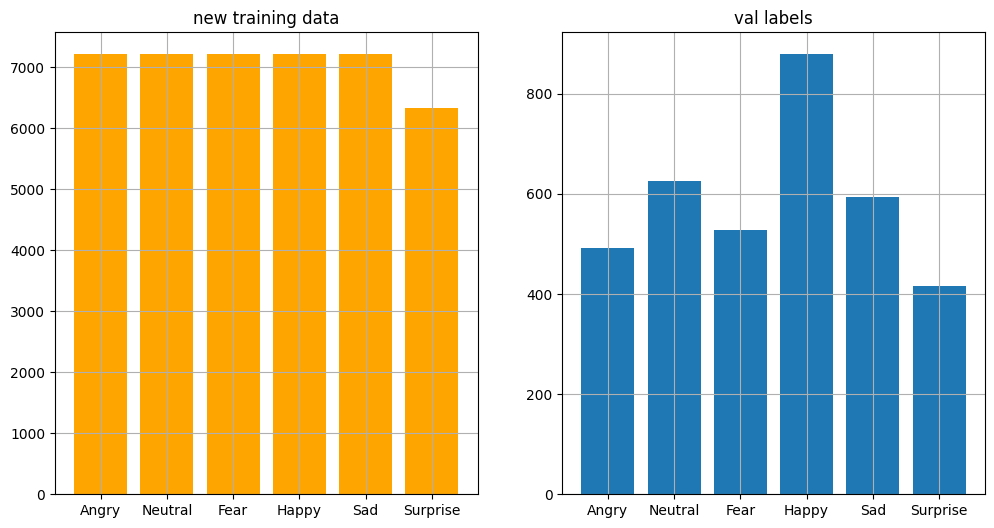

In [36]:
plot_compare_distributions(mirrored_train_labels, val_labels, title1='new training data', title2='val labels')

In [52]:
# Simple CNN model
simple_model = models.Sequential()
simple_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
simple_model.add(BatchNormalization())
simple_model.add(MaxPool2D((2, 2)))
simple_model.add(Conv2D(64, (3, 3), activation='relu'))
simple_model.add(MaxPool2D((2, 2)))
simple_model.add(Conv2D(64, (3, 3), activation='relu'))
simple_model.add(Flatten())
simple_model.add(Dense(64, activation='relu'))
simple_model.add(Dense(6, activation='softmax'))

simple_model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = simple_model.fit(mirrored_train_images, mirrored_train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=20,
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/20
1326/1326 [==============================] - 7s 4ms/step - loss: 0.2360 - accuracy: 0.4063 - val_loss: 1.2894 - val_accuracy: 0.4813
Epoch 2/20
1326/1326 [==============================] - 6s 4ms/step - loss: 0.1991 - accuracy: 0.5095 - val_loss: 1.2203 - val_accuracy: 0.5102
Epoch 3/20
1326/1326 [==============================] - 6s 4ms/step - loss: 0.1844 - accuracy: 0.5473 - val_loss: 1.1471 - val_accuracy: 0.5535
Epoch 4/20
1326/1326 [==============================] - 6s 4ms/step - loss: 0.1722 - accuracy: 0.5792 - val_loss: 1.1460 - val_accuracy: 0.5586
Epoch 5/20
1326/1326 [==============================] - 6s 4ms/step - loss: 0.1615 - accuracy: 0.6057 - val_loss: 1.1756 - val_accuracy: 0.5501
Epoch 6/20
1326/1326 [==============================] - 6s 4ms/step - loss: 0.1500 - accuracy: 0.6353 - val_loss: 1.2286 - val_accuracy: 0.5509
Epoch 7/20
1326/1326 [==============================] - 6s 4ms/step - loss: 0.1385 - accuracy: 0.6646 - val_loss: 1.2353 - val_accuracy:

In [54]:
test_loss_simple, test_acc_simple = simple_model.evaluate(test_images, test_labels)
pred_test_labels_simple = simple_model.predict(test_images)
print('test accuracy:', test_acc_simple)

111/111 [==============================] - 0s 2ms/step
test accuracy: 0.5609962940216064


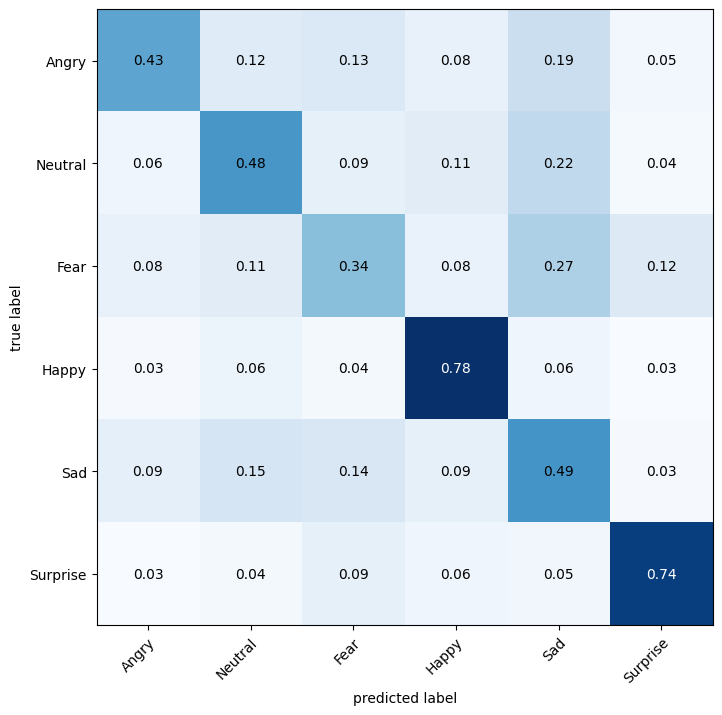

In [55]:
# analyze the confusion matrix to see what emotions are often confused
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels_simple.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

In [43]:
# initialize a densenet
densenet = DenseNet169(
    include_top=False,
    weights='imagenet',
    input_shape=(48,48,3)

)



layers_to_freeze = 25  # For example, freeze the first 15 layers

for layer in densenet.layers[:layers_to_freeze]:
    layer.trainable = False

# use transfer learning from vgg16
densenet_model = models.Sequential()
densenet_model.add(densenet)
densenet_model.add(Flatten())
densenet_model.add(Dropout(.3))
densenet_model.add(Dense(256, activation='relu'))
densenet_model.add(Dropout(.3))
# densenet_model.add(Dense(256, activation='relu'))
# densenet_model.add(Dropout(0.5))
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dense(6, activation='softmax'))

densenet_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])






51877672/51877672 [==============================] - 0s 0us/step


In [46]:
train_images_densenet = np.stack((mirrored_train_images[:, :, :, 0],)*3, axis=-1)

val_images_densenet = np.stack((val_images[:, :, :, 0],)*3, axis=-1)

test_images_densenet = np.stack((test_images[:, :, :, 0],)*3, axis=-1)

In [47]:
history = densenet_model.fit(train_images_densenet, mirrored_train_labels, epochs=20, batch_size=64, class_weight=class_weight, validation_data=(val_images_densenet, val_labels))

Epoch 1/20
663/663 [==============================] - 79s 119ms/step - loss: 0.2339 - accuracy: 0.4079 - val_loss: 2.3888 - val_accuracy: 0.3888
Epoch 2/20
663/663 [==============================] - 69s 105ms/step - loss: 0.1938 - accuracy: 0.5256 - val_loss: 1.1843 - val_accuracy: 0.5308
Epoch 3/20
663/663 [==============================] - 69s 104ms/step - loss: 0.1801 - accuracy: 0.5680 - val_loss: 1.1298 - val_accuracy: 0.5707
Epoch 4/20
663/663 [==============================] - 69s 104ms/step - loss: 0.1867 - accuracy: 0.5479 - val_loss: 1.1086 - val_accuracy: 0.5724
Epoch 5/20
663/663 [==============================] - 70s 105ms/step - loss: 0.1720 - accuracy: 0.5874 - val_loss: 1.0666 - val_accuracy: 0.5956
Epoch 6/20
663/663 [==============================] - 70s 105ms/step - loss: 0.1661 - accuracy: 0.6008 - val_loss: 1.0988 - val_accuracy: 0.5886
Epoch 7/20
663/663 [==============================] - 69s 104ms/step - loss: 0.1697 - accuracy: 0.5844 - val_loss: 1.0959 - val_ac

In [48]:
test_loss_densenet, test_acc_densenet = densenet_model.evaluate(test_images_densenet, test_labels)
pred_test_labels_densenet = densenet_model.predict(test_images_densenet)
print('test acc:', test_acc_densenet)

111/111 [==============================] - 4s 15ms/step
test acc: 0.6286442279815674


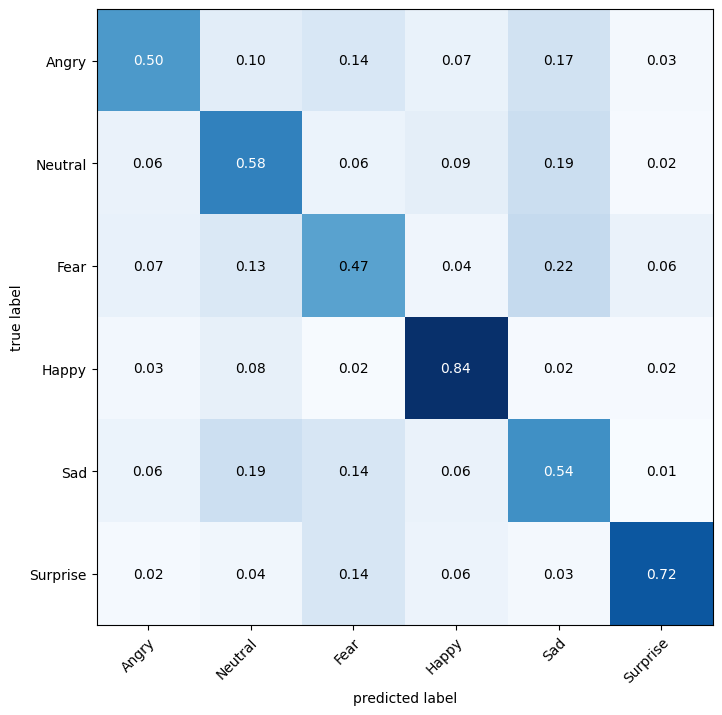

In [49]:
# analyze the confusion matrix to see what emotions are often confused
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels_densenet.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()